## Plotting hybrid model results

In [1]:
import xarray
import matplotlib.pyplot as plt
import seaborn
import numpy as np
import scipy
import dask
import warnings
import os
import cv2

import pickle
import jax_cfd.ml.newSaveObject as saving
import haiku as hk
import jax_cfd.ml.diego_towers as mytowers

In [2]:
print("ola")

ola


In [4]:
names = sorted(names)
names

['DNS_1024.nc',
 'DNS_2048.nc',
 'DNS_256.nc',
 'no_bcs.nc',
 'padding_and_pinn_bcs.nc',
 'padding_bcs.nc',
 'pinn_bcs.nc']

In [5]:
names = ['DNS_1080.nc',
 'DNS_256.nc',
 'no_bcs.nc',
 'padding_and_pinn_bcs.nc',
 'padding_bcs.nc',
 'pinn_bcs.nc']

In [6]:



def xarrayToList(model_name):
    ds = xarray.open_dataset(f"./sim30s/"+ model_name, chunks={'time': '100MB'})
    u = ds.u.values
    v = ds.v.values

    data = []
    for i in range(len(ds.time.values)):
    
        data.append(np.dstack([
            u[i][:][:],
            v[i][:][:]
        ]))


    return data

ground_truth = xarrayToList("DNS_2048.nc")
sim_1024 = xarrayToList("DNS_1024.nc")
sim_256 = xarrayToList("DNS_256.nc")


# LI = xarrayToList('VEL_SUPER_RES_BEST.nc')

In [27]:
# Create bicubic sample
def downSampling(data,factor):
    out = []
    for thisData in data:
        out.append(thisData[::factor,::factor,:])
    return out

def upSampling(data,factor):
    times,rows,cols,channels = np.shape(data)
    out = []
    for thisData in data:
        out.append(np.dstack([
            cv2.resize(thisData[:,:,0], dsize=(int(cols*factor), int(rows*factor)), interpolation=cv2.INTER_CUBIC),
            cv2.resize(thisData[:,:,1], dsize=(int(cols*factor), int(rows*factor)), interpolation=cv2.INTER_CUBIC)
        ]))
    return out

def createBicubicInterp(data,factor):
    return upSampling(downSampling(data,factor),factor)

def createSuperresInterp(data,factor,loaded):
    bicubic = createBicubicInterp(data,factor)
    
    # now superresolve
    out = []
    for thisTime in data:
        out.append(loaded.forward_pass.apply(loaded.params,thisTime) + thisTime)
    return out




def ConvNet(x):
    cnn = mytowers.CNN(CNN_specs)
    return cnn(x)

def makePath(name):
    return "./../training_models/models/" + str(name) +".pickle"


models = {
    0 : "no_bcs_1",
    1 : "padding_bcs_1",
    2 : "pinn_bcs_2",
    3 : "padding_and_pinn_bcs_1"
}


for i in range(len(models.keys())):
    model_path = makePath(models[i])
    

    with open(model_path,'rb',) as pickle_file:
        thisModel = pickle.load(pickle_file)
        CNN_specs = thisModel.CNN_specs
        thisModel.forward_pass = hk.without_apply_rng(hk.transform(ConvNet))
        models[i] = thisModel

    

    
sim_to_fit = sim_1024
allSuperresData = {}
for i in range(len(models)):
    print(i)
    CNN_specs = models[i].CNN_specs
    allSuperresData[i] = createSuperresInterp(sim_to_fit,4,models[i])
# superres_data = createSuperresInterp(sim_to_fit,4,loaded)
bicubic_data = createBicubicInterp(sim_to_fit,4)
# print("superres_data:\t" + str(np.shape(superres_data)) + "\n" + "bicubic_data:\t" + str(np.shape(bicubic_data)))

0
1
2
3


In [28]:
# np.gradient(data) # = [dy,dx]

def newVorticity(data):
#     dvdx -dudy
# axis = 0 -> y derivative
    out = []
    for thisTime in data:
        dvdx = np.gradient(thisTime[:,:,1],axis=1)
        dudy = np.gradient(thisTime[:,:,0],axis=0)
        out.append(dvdx-dudy)
    return out



In [29]:
ds = xarray.open_dataset(f"./sim30s/"+ "DNS_1024.nc")
times = ds.time.values

[]

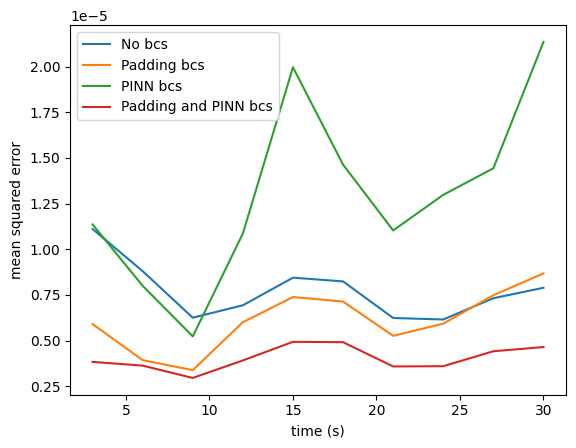

In [30]:
mse_superres = {}

mse_bicubic = np.zeros(len(allSuperresData[0]))

for model in range(len(allSuperresData.keys())):
    mse_superres[model] = np.zeros(len(allSuperresData[model]))
    for i in range(len(allSuperresData[model])):
        mse_superres[model][i] = np.mean((allSuperresData[model][i]-sim_to_fit[i])**2)
    
mse_bicubic[i] = np.mean((bicubic_data[i]-sim_to_fit[i])**2)


labels = {
    0 : "No bcs",
    1 : "Padding bcs",
    2 : "PINN bcs",
    3 : "Padding and PINN bcs",
}

styles = {
    0 : "k--",
    1 : "b--",
    2 : "r--",
    3 : "y--"
}

for i in range(len(allSuperresData.keys())):
    plt.plot(times,mse_superres[i],label=labels[i])
# plt.plot(times,mse_bicubic,label="bicubic interpolation")

plt.xlabel("time (s)")
plt.ylabel("mean squared error")
plt.legend()
plt.plot()

In [31]:


# time_ind = 4
# row = 500
# vel = 0


# x = np.linspace(0,2,256)
# print(np.shape(x))


# fig,ax = plt.subplots()
# ax.plot(x,sim_1024[time_ind][row,:,vel], "k-",markersize= 2,    label="Ground truth")
# ax.plot(x,bicubic_data[time_ind][row,:,vel],"r--",label="Interp without ML")
# ax.plot(x,superres_data[time_ind][row,:,vel],"c", label="Interp with ML")
# ax.legend()
# plt.xlabel("y")
# plt.ylabel("u")

# # inset axes....
# axins = ax.inset_axes([0.0, 0, 0.55, 0.3])
# axins.plot(x,sim_1024[time_ind][row,:,vel], "k-",markersize= 4,    label="1024")
# axins.plot(x,bicubic_data[time_ind][row,:,vel],"r--",label="bi-cubic only")
# axins.plot(x,superres_data[time_ind][row,:,vel],"c", label="bi-cubic + super-res")
# # subregion of the original image
# # plt.ylim([0,0.3])
# # plt.xlim([0,50])
# x1, x2, y1, y2 = 0, 0.3, 0, 0.3
# axins.set_xlim(x1, x2)
# axins.set_ylim(y1, y2)
# axins.set_xticklabels([])
# axins.set_yticklabels([])
# ax.indicate_inset_zoom(axins, edgecolor="black")

# plt.show()

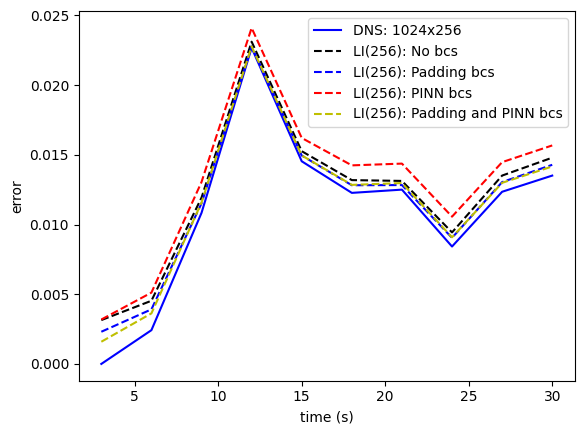

In [36]:
data = sim_1024

def calcWallErrors(data):
    errs = []
    for thisTime in data:

        walls = thisTime[:,0,:].flatten()
        np.array([walls,thisTime[:,-1,:].flatten()])

        errs.append(np.mean(abs(walls)))
    return errs

# plt.plot(times,calcWallErrors(ground_truth),"g",label="DNS: 2048x512")
plt.plot(times,calcWallErrors(sim_1024),"b",label="DNS: 1024x256")
# plt.plot(times,calcWallErrors(sim_256),"k",label="DNS: 256x64")
for i in range(len(allSuperresData.keys())):
    plt.plot(times,calcWallErrors(allSuperresData[i]),styles[i],label="LI(256): " + labels[i])
plt.xlabel("time (s)")
plt.ylabel("error")
plt.legend()

In [33]:
def reynoldsNumber(max_vel,nu,L):
    return L*max_vel/nu

def findVals(data,funct=np.max):
    out = []
    for frame in data:
        out.append(funct(frame))
    return out

max_vels = findVals(ground_truth)
Re_all = []
for v_max in max_vels:
    Re_all.append(reynoldsNumber(v_max,1e-4,2))
np.max(Re_all)


11906.603574752808